In [1]:
# import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")


# APC Biallelic Cancer Progression Probabilities, cBioPortal
This script calculates the cancer progression probabilities of APC genotypes using the frequencies of genotypes in the cBioPortal primary MSS CRC cohort (as outlined in main text Methods).


## 1. Import mutation probabiltiies and summary table of samples in cBioPortal

In [2]:
# import mutation probabilities data
null=pd.read_csv('Results/Mutation_probabilities_MSS.csv')
null=null.loc[0:9]
Types_double=[[0,0],[1,1],[2,2],[3,3],[0,1],[1,2],[1,3],[0,2],[2,3],[0,3]]
null['Type'] =Types_double
null['Type'] =null['Type'].apply(tuple)



# import CBio data
CBio=pd.read_csv('Data/cBioPortal/CBio_Data_MSS_no_cn.csv')
Types_double=[[0,0],[0,1],[0,2],[0,3],[1,1],[1,2],[1,3],[2,2],[2,3],[3,3]]
CBio['Type'] =Types_double
CBio['Type'] =CBio['Type'].apply(tuple)

print('Samples in cBio:', sum(CBio['Counts']))


Samples in cBio: 1041


## 2. Define functions to calculate progression probabilities and perform statistical analysis

In [6]:
# Function to calculate the progression probabilities from mutation probabilities and frequencies of APC genotypes

def progression_probability(df,null_=null):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    null_['Frequency']=np.asarray(entry_count)/sum(np.asarray(entry_count))
    
    
    probs=np.asarray(null_['Frequency'])/np.asarray(null_['Probabilities'])
    probs=probs/sum(probs)
    null_['Progression']=probs
    
    return np.asarray(null_['Progression'])

# Function to calculate the number of 20AARs with maximal progression probabiliy

def max_20AARs(df,null_=null):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    
    
    
    nullc=null_.groupby('20AARs',as_index=False).sum()

    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    
    max_row_index = nullc['Progression'].idxmax()
    value_in_column1 = nullc.loc[max_row_index, '20AARs']
    
    
    
    return int(value_in_column1)

# Function to calculate the progression-weighted mean number of 20AARs 

def mean_20AARs(df,null_=null):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    mean_20AAR=0
    for a in np.arange(7):
        mean_20AAR+=a*probs[a]
        

    return mean_20AAR
        
# Function to calculate the progression probabilities from mutation probabilities and frequencies of numbers of 20AARs

def progression_probability_20AARs(df,null_=null):
    
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs

    return np.asarray(   nullc['Progression'])

    
# Functions to find CI by bootstrapping

def bootstrap_func_values_ci(dataframe, func, n_iterations, confidence_level,*args):

    # Extract the specified column from the DataFrame
    values = dataframe['Type'].values
    try:
        N=len(func(dataframe,*args))
    except TypeError:
    # Handle the TypeError by returning '1'
        N= 1

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations, N))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = pd.DataFrame({'Type': np.random.choice(values, size=len(values), replace=True)})

        a=func(bootstrap_sample)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i, :] = func(bootstrap_sample,*args)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    alpha = (1 - confidence_level) / 2
    ci_lower_values = np.percentile(bootstrapped_values, alpha * 100, axis=0)
    ci_upper_values = np.percentile(bootstrapped_values, (1 - alpha) * 100, axis=0)

    return mean_values, ci_lower_values, ci_upper_values

def reproduce_dataset(original_dataframe):
    reproduced_dataset = []

    for _, row in original_dataframe.iterrows():
        entry, count = row['Type'], row['Counts']
        reproduced_dataset.extend([entry] * count)

    return pd.DataFrame({'Type': reproduced_dataset})

## 3. Calculate cancer progression probabilites, perform statistics and make plot for Figure 3


In [7]:

# Turn frequency table into dataset to use bootstrapping
df_CBio = reproduce_dataset(CBio)

pmn,lmn,hmn = bootstrap_func_values_ci(df_CBio, progression_probability, 1000, 0.95,null)
null['Progression Probability']=pmn
null['CIH']=lmn
null['CIL']=hmn
null_results=null
null_results.to_csv('Results/summary_cbio.csv')

# Bootstrapping of progression probability by 20AAR
px_m,lx_m,hx_m = bootstrap_func_values_ci(df_CBio, progression_probability_20AARs, 1000, 0.95,null)



# Bootstrapping of max 20AAR
Max,lmx,hmx = bootstrap_func_values_ci(df_CBio, max_20AARs, 1000, 0.99,null)
print('Max 20AARs:',int(Max),', 95% CI', lmx,hmx)
print('We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 99% CI for the maximal progression probability')
print('We conclude that data is consistent with Just right as 2 20AAR is in the 99% CI for the maximal progression probability')

# Bootstrapping of  progression-weighted mean number of 20AARs 
Meanx,Mlmx,Mhmx = bootstrap_func_values_ci(df_CBio, mean_20AARs, 1000, 0.95,null)
print('Progression-weighted mean number of total retained 20AARs in MSS, cBio cohort:',Meanx, ',95% CI', Mlmx,Mhmx)



Max 20AARs: 2 , 95% CI [2.] [2.]
We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 99% CI for the maximal progression probability
We conclude that data is consistent with Just right as 2 20AAR is in the 99% CI for the maximal progression probability
Progression-weighted mean number of total retained 20AARs in MSS, cBio cohort: [2.5557558] ,95% CI [2.2952267] [2.83215008]


In [8]:
# Weighted mean progression prbbalitye by samples counts

df= reproduce_dataset(CBio)
entry_count=[]
for t in list(null['Type']):
    entry_count.append(len(df[df['Type'] == t]))
null['Counts']=entry_count

mean0=null['Progression'][0]*null['Counts'][0] 
mean0=mean0/null['Counts'][0] 

mean1=null['Progression'][4]*null['Counts'][4] 
mean1=mean1/null['Counts'][4] 
             
mean2=null['Progression'][1]*null['Counts'][1] + null['Progression'][7]*null['Counts'][7]
mean2=mean2/(null['Counts'][1] + null['Counts'][7]  )

mean3=null['Progression'][5]*null['Counts'][5] + null['Progression'][9]*null['Counts'][9] 
mean3=mean3/(null['Counts'][5] + null['Counts'][9]  )

mean4=null['Progression'][2]*null['Counts'][2] + null['Progression'][6]*null['Counts'][6]
mean4=mean4/(null['Counts'][2] + null['Counts'][6] )

mean5=null['Progression'][8]*null['Counts'][8] 
mean5=mean5/(null['Counts'][8] )

mean6=null['Progression'][3]*null['Counts'][3] 
mean6=mean6/(null['Counts'][3]  )

weighted_mean = np.asarray([mean0,mean1,mean2,mean3,mean4,mean5,mean6])

# Find R2 fit 
interpolated_function = interp1d(np.arange(7), weighted_mean, kind='linear', fill_value="extrapolate")
predicted_y = interpolated_function(np.asarray(null['20AARs']))
r2 = r2_score(np.asarray(null['Progression']), predicted_y)

print("R-squared fit between progerssion probailities by genotype and total 20AARs:", r2)

R-squared fit between progerssion probailities by genotype and total 20AARs: 0.8731374450778175


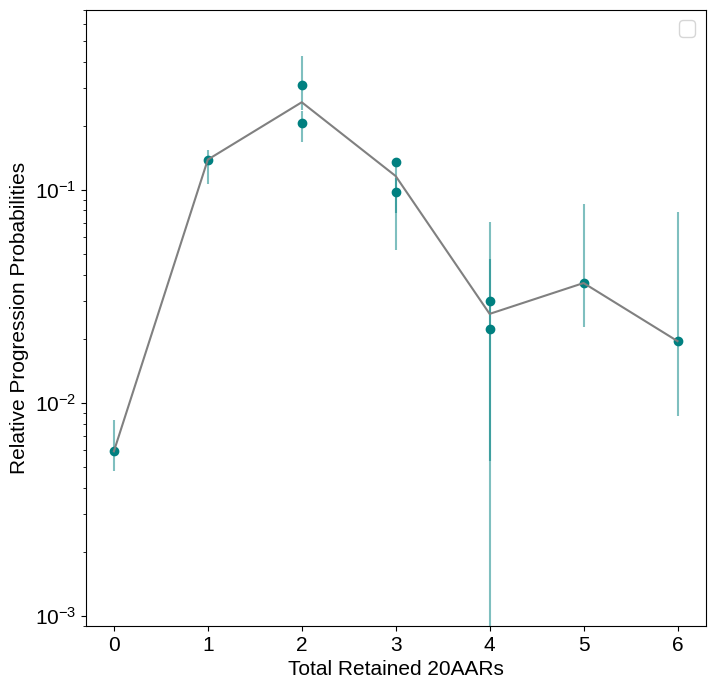

In [9]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.asarray(null['20AARs']),np.asarray(null['Progression']),'o',color='teal')
for i in np.arange(len(null)):
    plt.vlines(np.asarray(null['20AARs'][i]),np.asarray(null['CIL'][i]),np.asarray(null['CIH'][i]),color='teal',alpha=0.5)#

    
mean=null['Progression'].groupby(null['20AARs']).mean()    
plt.plot(np.arange(7),np.asarray(mean),'-',color='grey')#, label='Mean')

plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()
plt.ylim([0.0009,0.7])

plt.savefig('Results/supplementary_cbio.svg',dpi=300)

## Import 100kGP result and plot together

In [10]:

progression_20AARs=pd.read_csv('Results/MSS_100KGP_by_20AARs.csv')
px_100=np.asarray(progression_20AARs['100KGP Progression Probability'])
lx_100=np.asarray(progression_20AARs['CLow'])
hx_100=np.asarray(progression_20AARs['CHigh'])

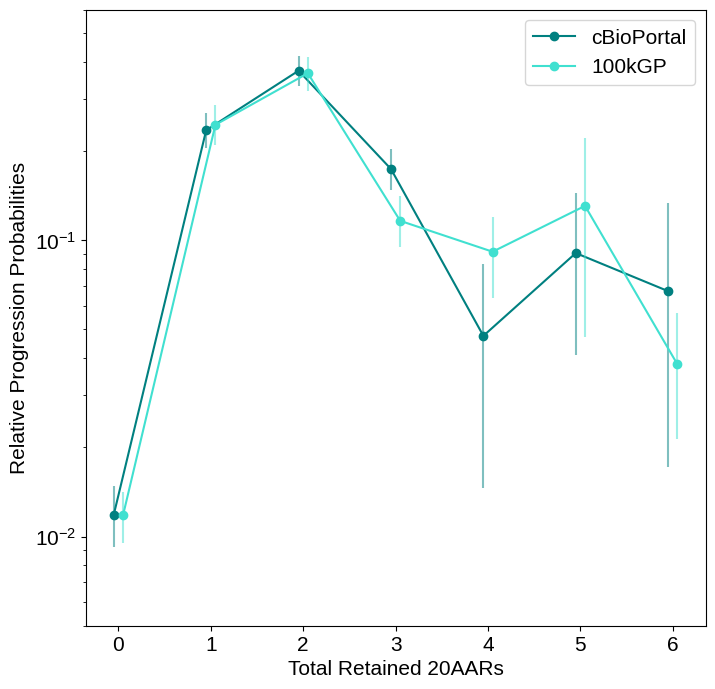

In [11]:

plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(7)-0.05,px_m,'o-',color='teal',label='cBioPortal')
plt.vlines(np.arange(7)-0.05,lx_m,hx_m,color='teal',alpha=0.5)#


plt.plot(np.arange(7)+0.05,px_100,'o-',color='turquoise',label='100kGP')
plt.vlines(np.arange(7)+0.05,lx_100,hx_100,color='turquoise',alpha=0.5)#
plt.ylim([0.005,0.6])
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()
plt.savefig('Results/Fig3G.svg',dpi=300)

         